## Second selection of GW stations based on the percentage of missing data

In [1]:
import pandas as pd
from datetime import datetime
from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import folium

In [2]:
# Import data and metadata

# Load Metadata 
metadata_path = "stations_metadadata22_active.xlsx"
meta_df = pd.read_excel(metadata_path)


# Load data
df_path = "C:/Users/ecig/Documents/Python Scripts/ANIN/cleaned_stations22_active.xlsx"
df = pd.read_excel(df_path)
df = df.iloc[:,1:]

,A2N0001,A2N0005,A2N0014,A2N0091,A2N0100,A2N0116,A2N0119,A2N0121,A2N0124,A2N0131,...,X2N0041,X2N0042,X2N0043,X3N0005,X3N0006,X3N0007,X3N0009,X3N0010,X3N0011,X3N0013
0,NaN,NaN,NaN,NaN,NaN,-2.050,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,-8.640,NaN,NaN,-4.020,-22.28,-8.48,-25.88,-9.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,-8.510,NaN,NaN,-2.430,-22.32,-8.15,-27.99,-9.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,-7.864,NaN,NaN,-1.460,NaN,NaN,NaN,-11.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,-7.259,NaN,NaN,-1.287,NaN,NaN,NaN,-9.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,NaN,NaN,NaN,NaN,NaN,-1.992,NaN,NaN,NaN,NaN,...,-27.63,-77.59,-39.34,-15.76,-4.16,-19.91,-3.13,-19.61,-33.71,-30.06
270,NaN,NaN,NaN,NaN,NaN,-1.835,NaN,NaN,NaN,NaN,...,-27.70,-77.59,-39.33,-15.87,-4.28,-19.90,-3.24,-19.73,-33.77,-30.08
271,NaN,NaN,NaN,NaN,NaN,-1.610,-16.50,-1.50,-17.80,-1.47,...,-27.42,-77.54,-38.49,-15.76,-4.01,-19.96,-3.29,-19.81,-33.78,-30.08
272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-27.65,-77.52,-39.10,-15.77,-4.91,-19.91,-3.30,-19.18,-33.71,-30.09


In [4]:
# Create a time vector for the time series
sdate = '1999-10-01'   # start date
edate = '2022-07-28'   # end date
start_date = pd.to_datetime(sdate)
end_date = pd.to_datetime(edate)
dates = pd.date_range(start_date,end_date, freq='MS')

In [5]:
# Compute the percentage of NaNs for the entire time series.

dfT = df.T
percentage_nans_dict = {}
for col in df.columns:
    num_nans = df[col].isna().sum()
    percent = num_nans / len(df) * 100
    percentage_nans_dict[col] = percent
    
# Create a pandas Series from the dictionary
percentage_nans = pd.Series(percentage_nans_dict)
percentage_nans = percentage_nans.T


In [6]:
# Create a boolean mask & use the mask to select the stations with values below 80%
mask = percentage_nans < 80
selected_stations = percentage_nans[mask]

# Get the corresponding indices
selected_indices = selected_stations.index

# Select corresponding GW data from using selected_indices
df_selected = dfT.loc[selected_indices]

print('Number of selected stations: ' + str(len(selected_stations)))

Number of selected stations: 1318


Compare selected_indices and df_selected to ensure that the right stations are selected:

In [7]:
# Convert the indices to strings
selected_indices_str = [str(index) for index in selected_indices]
df_indices_str = [str(index) for index in df_selected.index]

# Check if the selected indices match the DataFrame indices
matching_indices = [index for index in selected_indices_str if index in df_indices_str]

# Compare the lengths and raise an error if they don't match
if len(matching_indices) != len(selected_indices):
    raise ValueError("The selected indices do not match the indices in the DataFrame.")
else:
    print("Indices successfully matched! Good station selection :)")


Indices successfully matched! Good station selection :)


Continue the stations selection process based on the annual percentage of NaNs

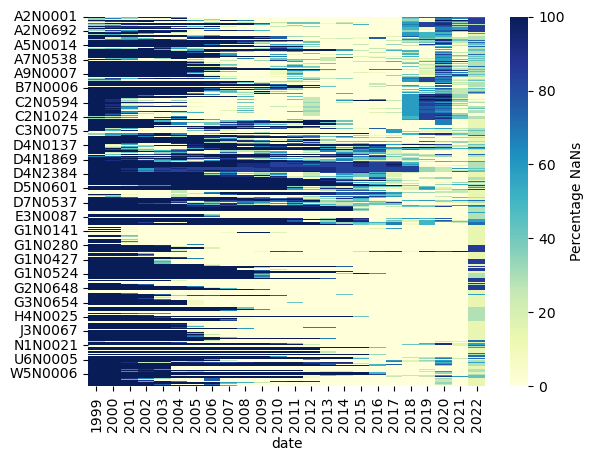

In [8]:
# Compute annual percentage of missing values of the sations with less than 80% of missing values.
df_selected = df_selected.T
df_selected['date'] = dates
yearly_nan_percentages = df_selected.groupby(df_selected['date'].dt.year).apply(lambda x: x.isna().sum() / len(x) * 100)

# Repeat heatmap of annual NaNs per station
import seaborn as sns
sns.heatmap(yearly_nan_percentages.T, cmap='YlGnBu', cbar_kws={'label': 'Percentage NaNs'}, xticklabels=True)

# Save figure
plt.savefig('Annual_NaNpercent_80.png')


In [9]:
# Define a function to check for consecutive values:  The NaN_threshold sets the NaN percent tolerance
# The consecutive_threshold sets the maximum number of consecutive years above the NaN threshold.

def check_consecutive(df,NaN_threshold,consecutive_threshold):
    consecutive_count = 0
    for value in df:
        if value >= NaN_threshold:
            consecutive_count += 1
            if consecutive_count >= consecutive_threshold:
                return True
        else:
            consecutive_count = 0
    return False

Apply the function above to  yearly_nan_percentages 

In [10]:
# List to store columns to be removed
columns_to_remove = []

# Iterate over each column
for column in yearly_nan_percentages.columns:
    # Check for consecutive values in the column
    if check_consecutive(yearly_nan_percentages[column],80,12):
        columns_to_remove.append(column)

# Remove the columns from the dataframe
df_consec_NaNs = yearly_nan_percentages.drop(columns_to_remove, axis=1)

# Remove the columns from the GW data
df_selected_yearly = df_selected.drop(columns_to_remove, axis=1)

print('Initial number of stations: ' + str(yearly_nan_percentages.shape[1]))
print('Stations to remove: ' + str(len(columns_to_remove)))
print('The final number of selected stations is: ' + str(df_selected_yearly.shape[1]))


Initial number of stations: 1319
Stations to remove: 256
The final number of selected stations is: 1063


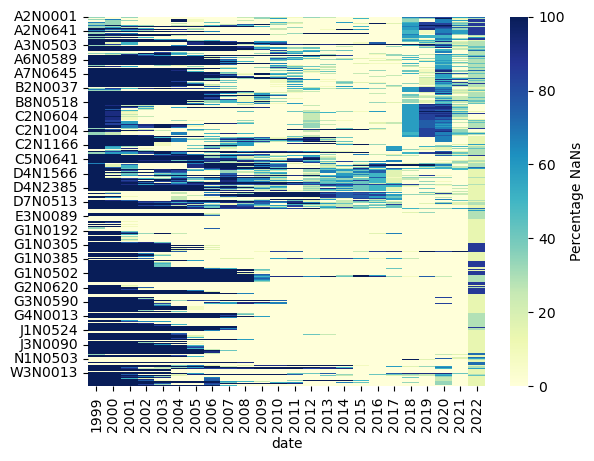

In [11]:
# Repeat heatmap for final station selection
import seaborn as sns
sns.heatmap(df_consec_NaNs.T, cmap='YlGnBu', cbar_kws={'label': 'Percentage NaNs'}, xticklabels=True)

# Save figure
plt.savefig('Annual_NaNpercent_consecutive.png')


Get the metadata of the final selection of stations

In [12]:
# Get the column names of the selected stations
selected_columns = df_selected_yearly.columns

# Select the corresponding information in the metadata dataframe using isin()
meta_selected_yearly = meta_df[meta_df['Station'].isin(selected_columns)]

In [13]:
print('metadata len:',len(meta_selected_yearly))
print('selected columns len:',len(selected_columns))

metadata len: 1062
selected columns len: 1063


In [16]:
# Create a map centered at the mean coordinates of the data
center_lat = meta_selected_yearly["Latitude"].mean()
center_lon = meta_selected_yearly["Longitude"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Add markers for each data point
for index, row in meta_selected_yearly.iterrows():
    lat = row["Latitude"]
    lon = row["Longitude"]
    len_obs = row["lenObs_yr"]
    marker_text = f"lenObs_yr: {len_obs}"
    folium.Marker(location=[lat, lon], popup=marker_text).add_to(m)
m